# 1. Calibrate the Camera

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
# import modules for this project
#import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import glob

# Read in and make a list of calibration chessboard images 
chessboard_images = glob.glob('./camera_cal/calibration*.jpg') # Chessboard images
test_images = glob.glob('./test_images/*.jpg')  # Test images

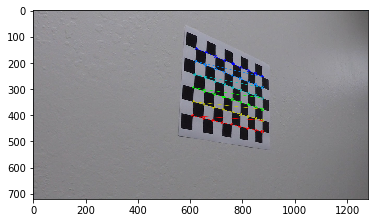

In [3]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0, 0, 0), (1, 0, 0) ..., (8, 5, 0)
objp = np.zeros((6*9, 3), np.float32)
# Generate the x and y coordinates and shape them into two columns
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

for fname in chessboard_images:
    # read in each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If coners are found, add object points, image points
    if ret == True:
        
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw detected corners on the chessboard image and store it 
        name = './output_images/draw_corners/' + fname.split('/')[-1]
        img_draw = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img_draw)
        plt.savefig(name)
        
cv2.destroyAllWindows()

In [4]:
# Save the objpoints and imgpoints arrays
np.save('./output_images/imgpoints.npy', imgpoints)
np.save('./output_images/objpoints.npy', objpoints)

# 2. Correct for Image Distortion

Apply a distortion correction to raw images.

In [5]:
def cal_undistort(img):
    """
    The function performs the camera calibration
    and images distortion correction, 
    returns the undistorted image. 
    [img] a distorted 2D image
    [objpoints] the coordinates of the corners in undistorted 3D images
    [imgpoints] the coordinates of the corners in distorted 2D images.
    """
    # Load objpoints and imgpoints
    imgpoints = np.load('./output_images/imgpoints.npy')
    objpoints = np.load('./output_images/objpoints.npy')
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the camera matrix and distortion coefficients to transform 3D image points to 2D image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Undistort the input image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist    

In [6]:
img_chessboard = mpimg.imread('./camera_cal/calibration3.jpg')
img_lane = mpimg.imread(test_images[0])

In [7]:
undistorted1 = cal_undistort(img_chessboard)
undistorted2 = cal_undistort(img_lane)

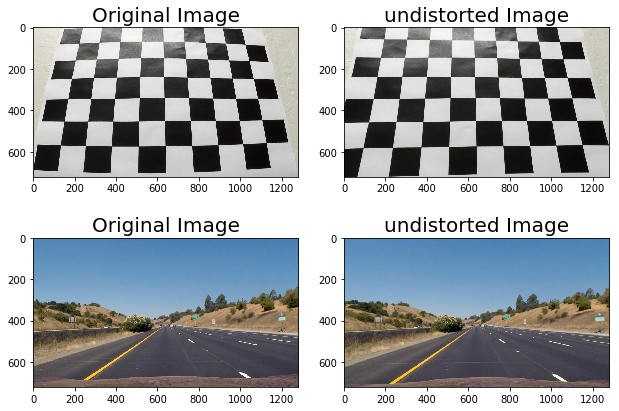

In [8]:
f, arr = plt.subplots(2, 2, figsize=(8, 6))
f.tight_layout()
arr[0,0].set_title('Original Image', fontsize=20)
arr[0,0].imshow(img_chessboard)
arr[1,0].set_title('Original Image', fontsize=20)
arr[1,0].imshow(img_lane)
arr[0,1].set_title('undistorted Image', fontsize=20)
arr[0,1].imshow(undistorted1)
arr[1,1].set_title('undistorted Image', fontsize=20)
arr[1,1].imshow(undistorted2)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/undistorted_test.jpg')

# 3. Implement a Color & Gradient Threshold

Use color transform, gradients, etc., to create a threshold binary image.

__Note__: Make sure you use the correct grayscale conversion depending on how you've read in your images. Use `cv2.COLOR_RGB2GRAY` if you've read in an image using `mpimg.imread()`. Use `cv2.COLOR_BGR2GRAY` if you've read in an image using `cv2.imread()`.

## 3.1 Load and display original test images

In [9]:
# load all test images
images= []
names = []
for fname in test_images:
    # load and append test image
    img = mpimg.imread(fname)
    images.append(img)
    # pick image name out of file path
    name = fname.split('/')[-1].split('.')[0]
    names.append(name)

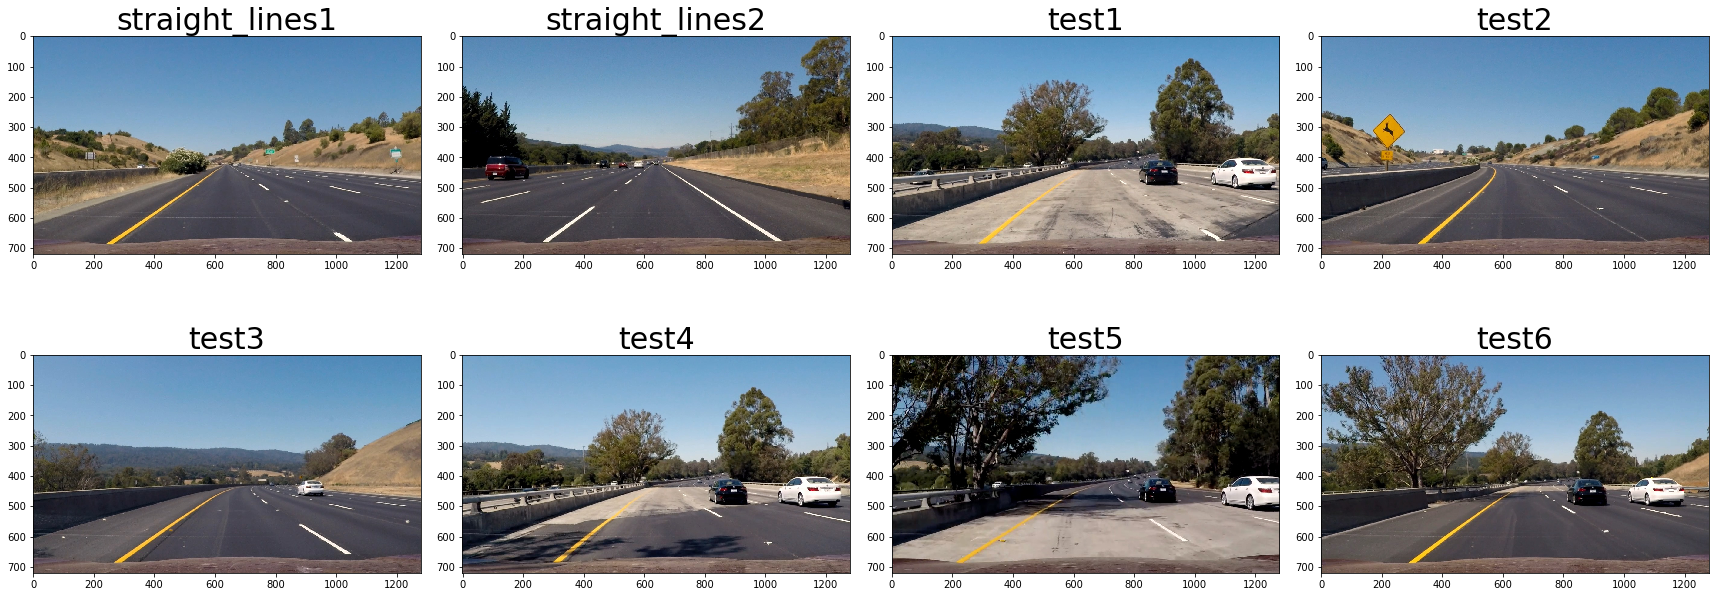

In [10]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    r = i//4  # row of image
    c = i - r*4  # colomn of image
    arr[r,c].imshow(images[i], cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/load_images.jpg')

## 3.2 HLS threshold

In [11]:
def hls_select(img, thresh=(0, 255)):
    """
    Define a fucntion that thresholds the S-channel of HLS.
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]  # S channel picks up the lines well
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

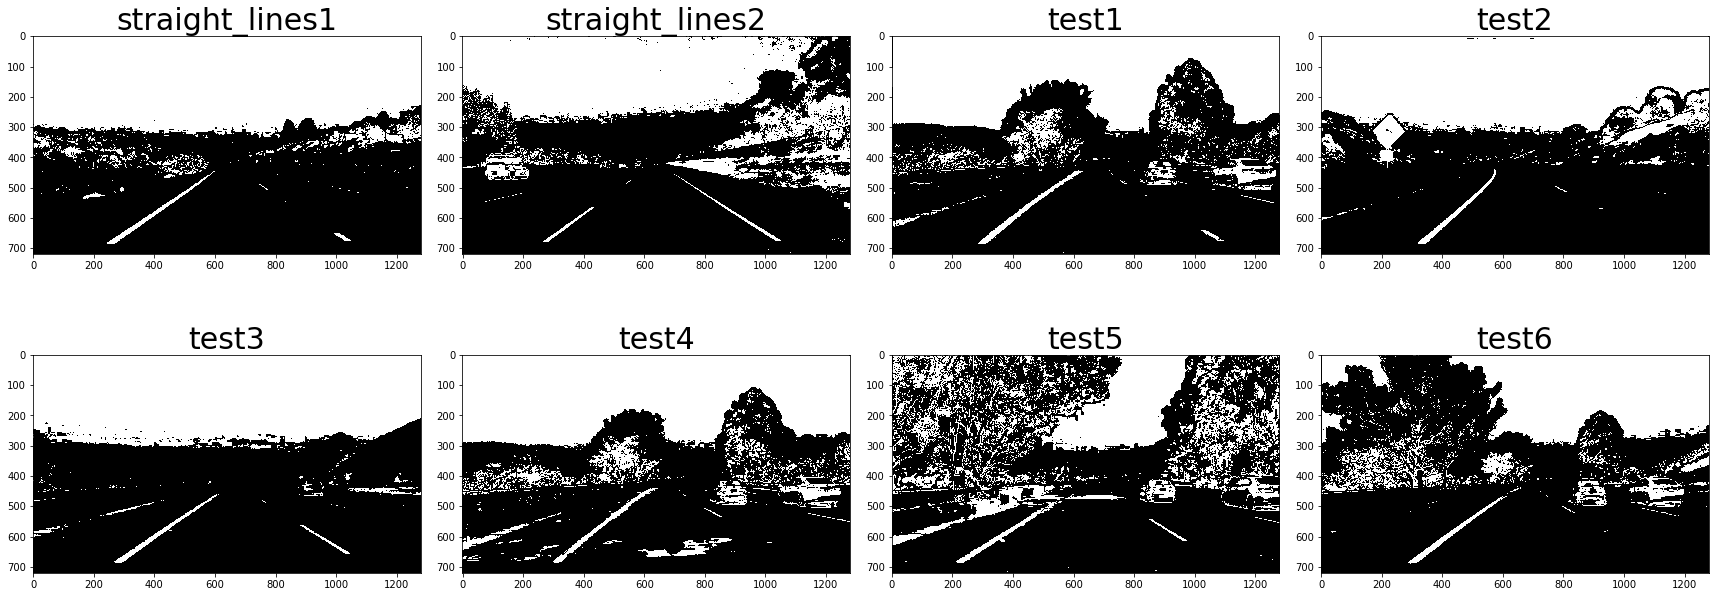

In [12]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = hls_select(images[i], thresh=(90, 255))
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/HLS.jpg')

## 3.3 Gradient Threshold
### 3.3.1 Absolute Value of the Gradient

In [13]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    """
    The function applies Sobel x and y,
    then takes an absolute value and applies a threshold.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

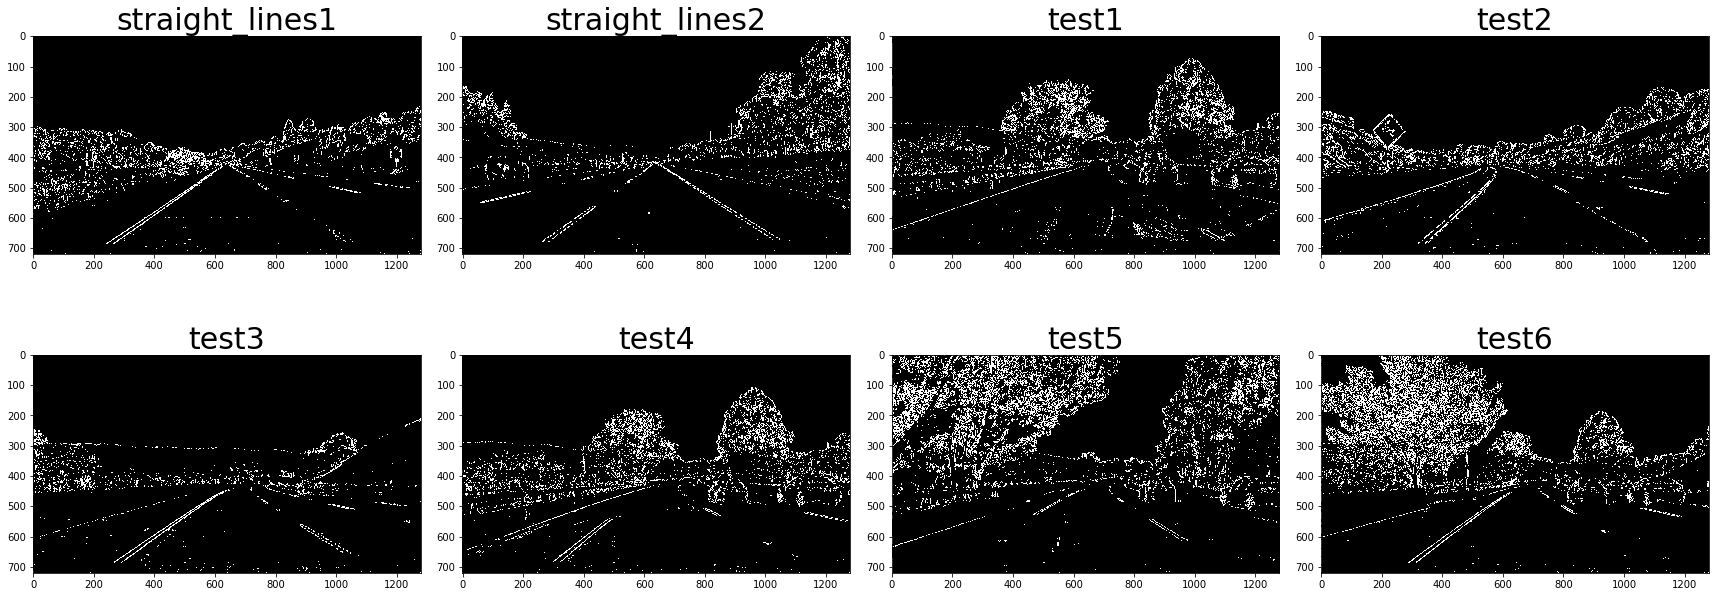

In [14]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = abs_sobel_thresh(images[i], orient='x', thresh_min=20, thresh_max=100)
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/abs_sobel_thresh.jpg')

### 3.3.2 Magnitude of the Gradient

In [15]:
def mag_thresh(img, sobel_kernel, mag_thresh=(0, 255)):
    """
    The function returns the magnitude of the gradient
    for a given sobel kernel size and threshold values.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate gardient magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2, sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)   
    # Apply threshold
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

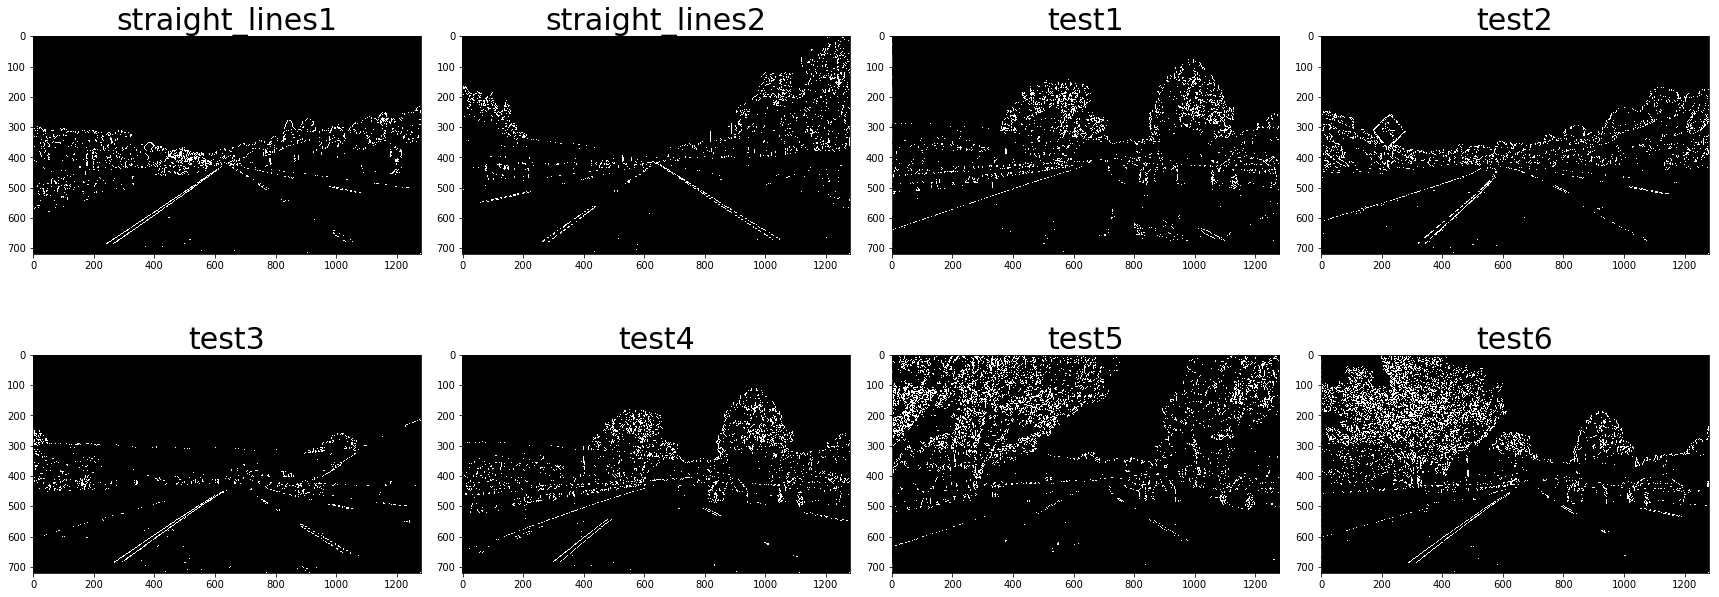

In [16]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = mag_thresh(images[i], sobel_kernel=3, mag_thresh=(30, 100))
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/mag_thresh.jpg')

### 3.3.3 Direction of the Gradient

In [17]:
def dir_threshold(img, sobel_kernel, thresh=(0, np.pi/2)):
    """
    The function applies Sobel x and y, then compute the
    direction of the gradient and applies a threshold.
    """
    #gray = hls_select(img, thresh=(90, 255))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate gradient direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Apply threshold
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

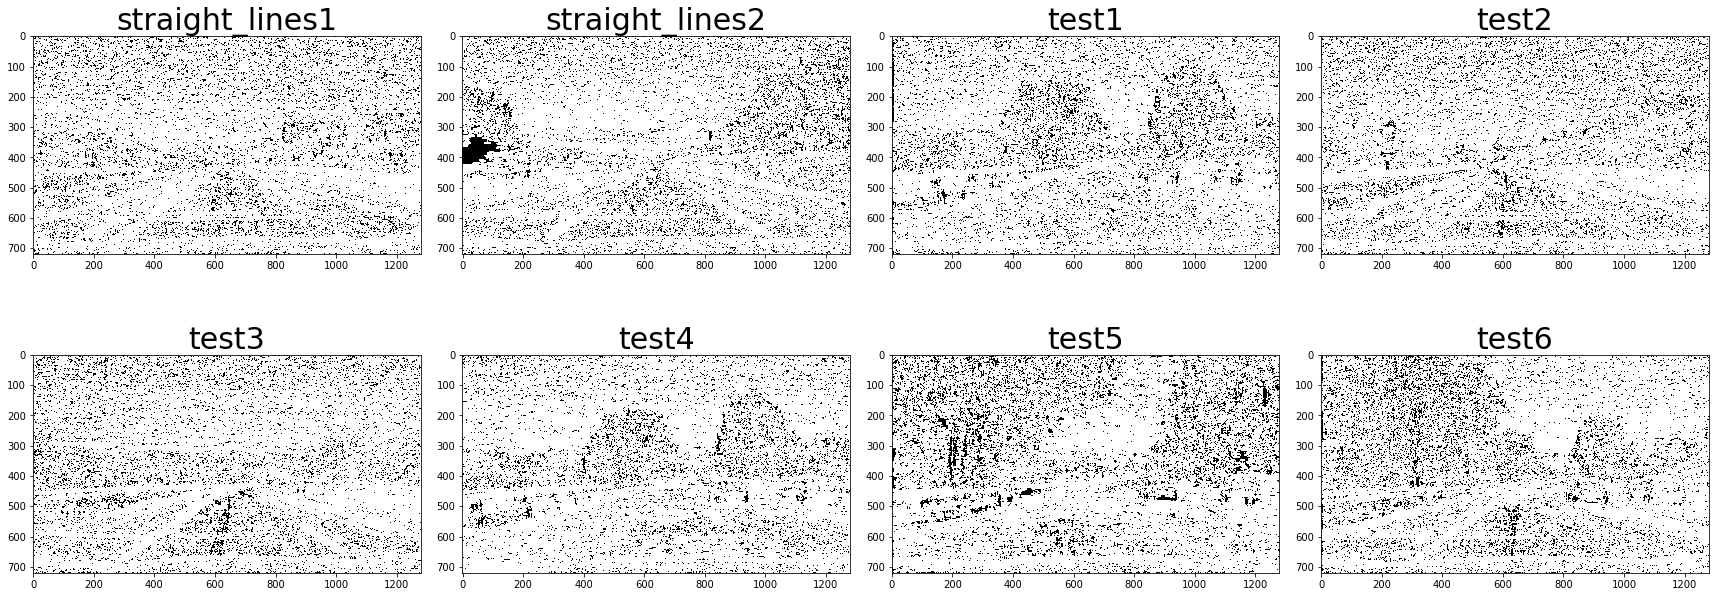

In [18]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = dir_threshold(images[i], sobel_kernel=15, thresh=(0.3, 1.7))
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/dir_threshold.jpg')

### 3.3.4 Combing Gradient Thresholds

In [19]:
def combine_gradient(img):
    """
    The function combines gradient, magnitude of gradient and 
    direction of gradient thresholds.
    """
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary =  mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=9, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx==1) & (grady==1)) | ((mag_binary==1) & (dir_binary==1))] = 1
    
    return combined

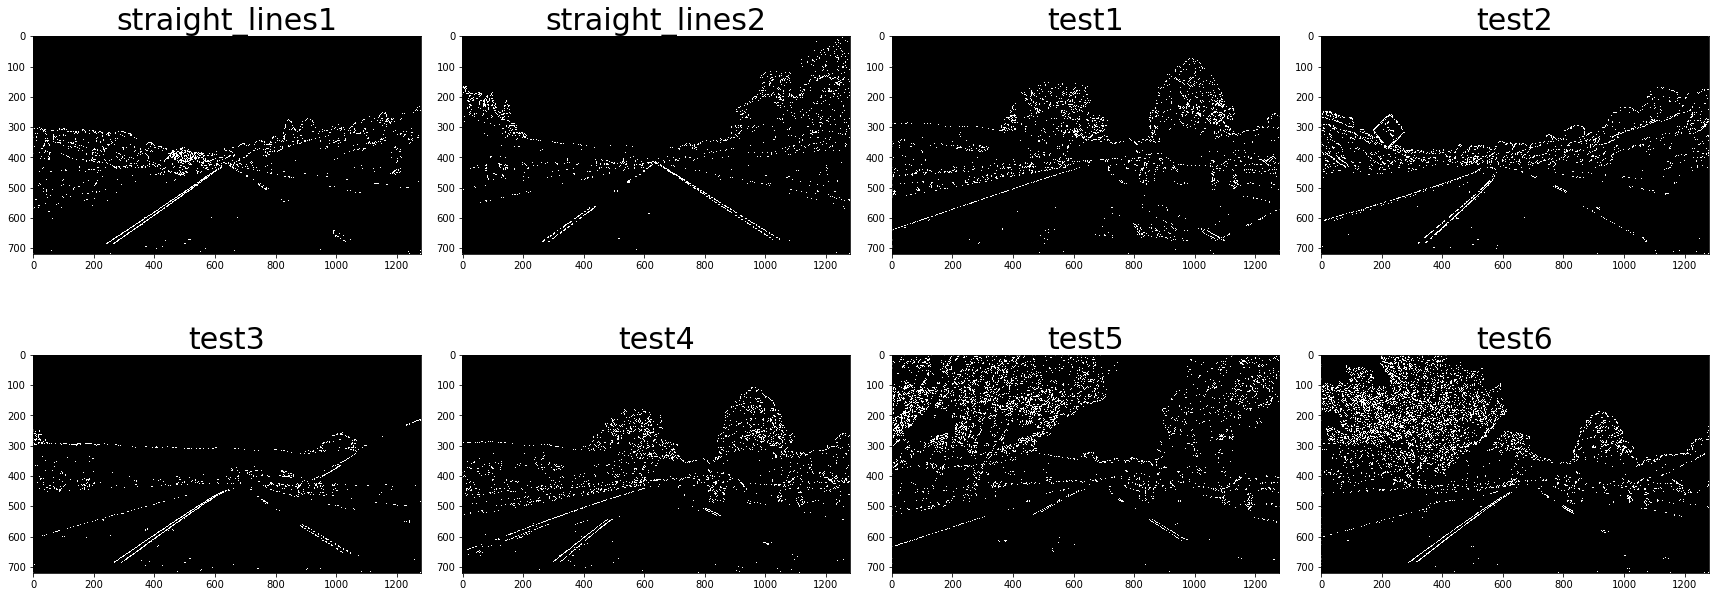

In [20]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = combine_gradient(images[i])
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/combine_gradient.jpg')

## 3.4 Combining Color and Gradient Thresholds

In [21]:
def color_grad(img):
    """
    The function combines HLS color threshold and multiple gradient thresholds.
    """
    color_binary = hls_select(img, thresh=(90, 255))
    gradient_binary = combine_gradient(img)
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(color_binary == 1) | (gradient_binary == 1)] = 1
    
    return combined_binary

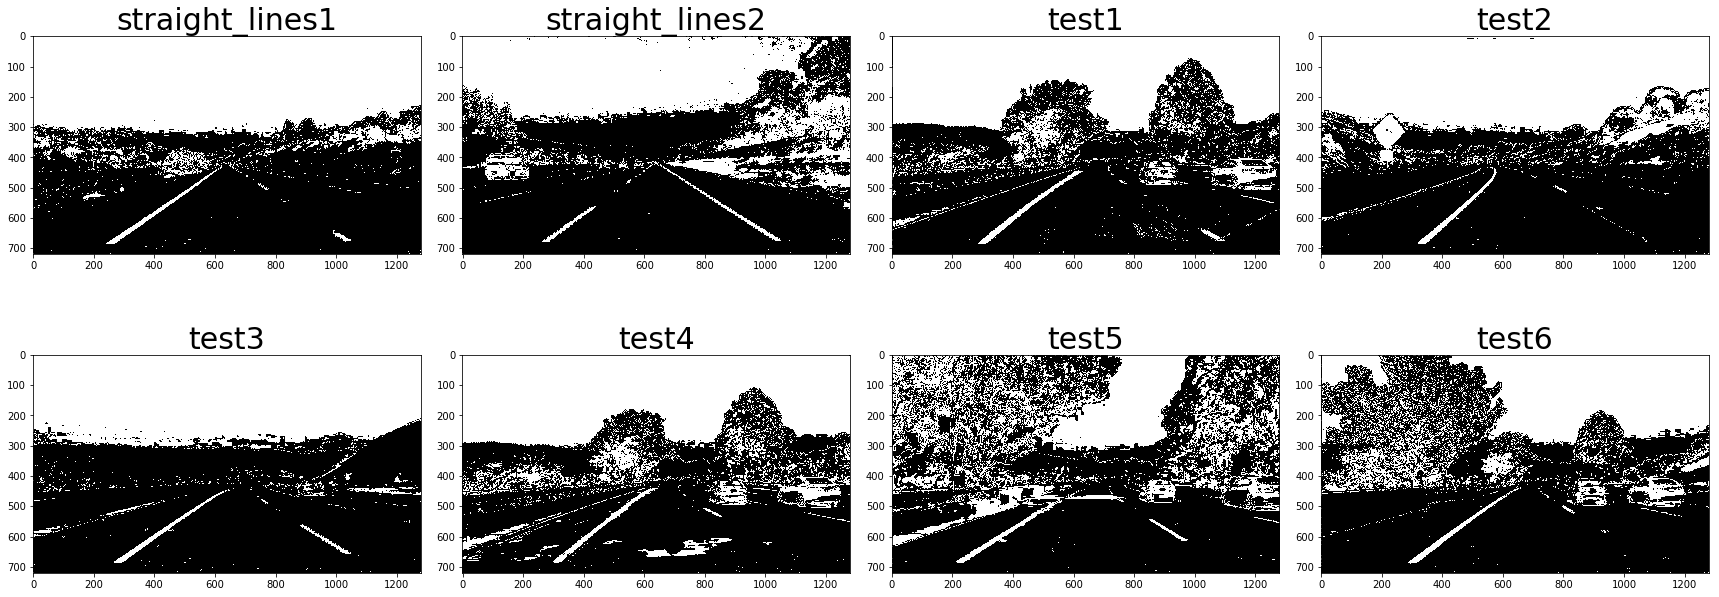

In [22]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = color_grad(images[i])
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/color_grad.jpg')

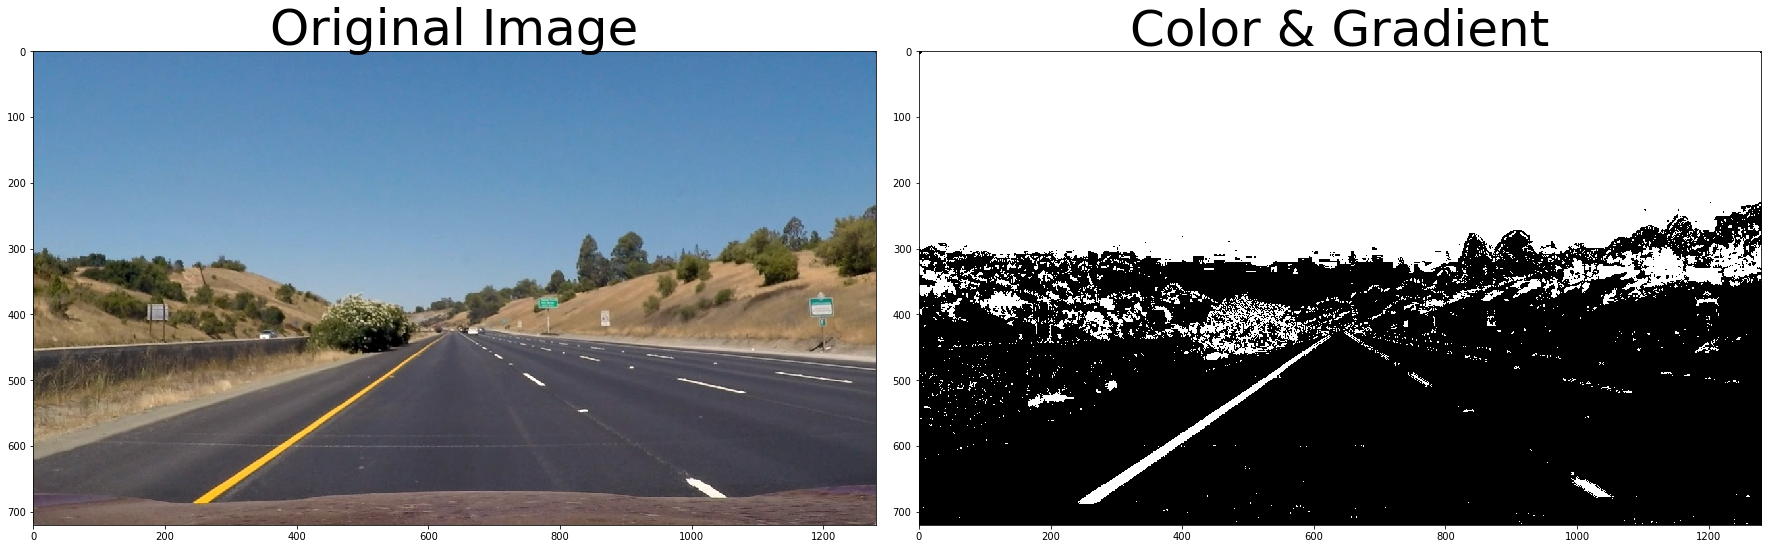

In [24]:
# Run the function
combine_binary = color_grad(img_lane)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_lane)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combine_binary, cmap='gray')
ax2.set_title('Color & Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/thresholds.jpg')

# 4. Warp the Image Using Perspective Transform

Apply a perspective transform to rectify binary image("birds-eye view").

In [32]:
img_size = img_lane.shape

In [53]:
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

In [54]:
pts = np.int32(src.reshape((-1,1,2)))
pts

array([[[ 305,  740]],

       [[ 110, 1280]],

       [[ 660, 1280]],

       [[ 415,  740]]], dtype=int32)

In [ ]:
cv2.polylines(img_lane, [pts], True, (0,255,255), 3)
cv2.imshow(img_lane)

In [34]:
src, dst

(array([[ 305.,  740.],
        [ 110., 1280.],
        [ 660., 1280.],
        [ 415.,  740.]], dtype=float32), array([[ 180.,    0.],
        [ 180., 1280.],
        [ 540., 1280.],
        [ 540.,    0.]], dtype=float32))

In [28]:
def warper(img):
    """
    Define caliation box in source (original)
    and destination (desired or warped) coordinates. 
    """
    img_size = (img.shape[1], img.shape[0])
    # Four source coordinates
    src = np.float32([[260,680], 
                      [580,460],
                      [705,460], 
                      [1050,680]])
    # Four desired coordinates
    dst = np.float32([[380,720], [380,0], [980,0], [980,720]])
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

In [29]:
def warp_camera(img_camera):
    """
    The input is the original image taken by camera.
    The function undistort the original image, apply a color&gradient threshold
    on the undistorted image and warp the binary image in bird-eye perspection.
    """
    img_undistort = cal_undistort(img_camera)
    img_threshold = color_grad(img_undistort)
    img_warped, M, Minv = warper(img_threshold)
    return img_undistort, img_warped, M, Minv

In [27]:
img4 = mpimg.imread(test_images[0])
img5 = mpimg.imread(test_images[1])

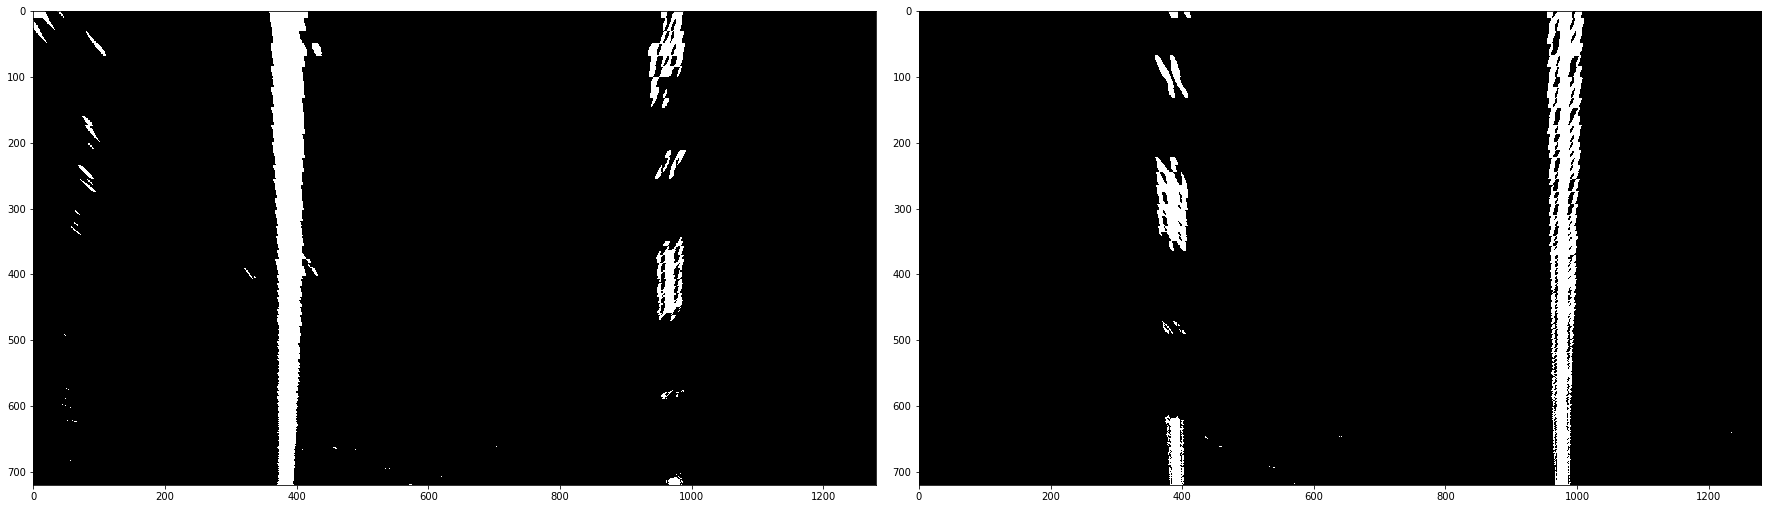

In [20]:
undistorted4, warp4, M4, Minv4 = warp_camera(img4)
undistorted5, warp5, M5, Minv5 = warp_camera(img5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warp4, cmap='gray')
#ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warp5, cmap='gray')
#ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# 5. Decide Which Pixels Are Lane Line Pixels

Detect lane pixels and fit to find the lane boundary

In [21]:
def window_mask(width, height, img_ref, center,level):
    """
    The function is used to draw window areas.
    """
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [22]:
def find_window_centroids(binary_warped, window_width, window_height, margin):
    """
    The function find all the left and right window centroids 
    for each level in the given binary image.
    """
    window_centroids = [] # Store the (left, right) window centroid positions per level
    window = np.ones(window_width) # Create out window template that we will use for convolutions
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,:int(binary_warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,int(binary_warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(binary_warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,int(binary_warped.shape[0]/window_height)):
        # Convolve the window into the vertical slice of the image
        layer_bottom = int(binary_warped.shape[0]-(level+1)*window_height)
        layer_top = int(binary_warped.shape[0]-level*window_height)
        image_layer = np.sum(binary_warped[layer_bottom:layer_top, :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    return window_centroids

In [23]:
# Window settings
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 40 # How much to slide left and right for searching

In [24]:
def mark_centroids(binary_warped, window_width, window_height, margin):
    """
    The function find and mark left and right centroids.
    """
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1))] = 255
            r_points[(r_points == 255) | ((r_mask == 1))] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green 
        warpage = np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results 

    # If no window centers found, just display original road image 
    else:
        output = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)),np.uint8)
    
    return output

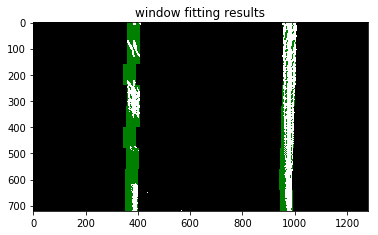

In [25]:
mark_centroids5 = mark_centroids(warp5, window_width, window_height, margin)
# Display the final results
plt.imshow(mark_centroids5)
plt.title('window fitting results')
plt.show()

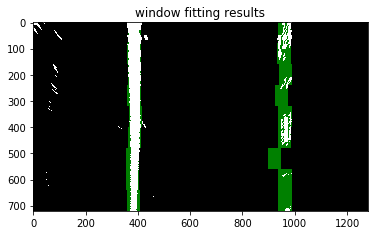

In [26]:
mark_centroids4 = mark_centroids(warp4, window_width, window_height, margin)
# Display the final results
plt.imshow(mark_centroids4)
plt.title('window fitting results')
plt.show()

In [27]:
def find_ploty(binary_warped, window_centroids, window_height, window_width):
    """
    The function extract left and right line pixel positions
    to fit a second order polynomial to both, and generate x and y for plotting.
    """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive valid left and right lane point coordinates
    leftx = []
    lefty = []
    rightx = []
    righty = []

    # Go through each level to find
    for level in range(0, len(window_centroids)):

        # Identify window areas
        #l_mask = window_mask(window_width, window_height, binary_warped, window_centroids[level][0], level)
        #r_mask = window_mask(window_width, window_height, binary_warped, window_centroids[level][1], level)
        l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
        l_mask = np.array(l_mask)
        r_mask = np.array(r_mask)
        # Identify the nonzero pixels in x and y within the window
        good_left = (binary_warped*l_mask).nonzero()
        good_right = (binary_warped*r_mask).nonzero()
        # Append these coordinates to the lists
        lefty.append(good_left[0])
        leftx.append(good_left[1])
        righty.append(good_right[0])
        rightx.append(good_right[1])
    
    # Concatenate the arrays of nonzero pixel coordinates
    lefty = np.concatenate(lefty)
    leftx = np.concatenate(leftx)
    righty = np.concatenate(righty)
    rightx = np.concatenate(rightx)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Pack all x and y coordinates to cut down the numbers of output
    lane = np.array([lefty, leftx, righty, rightx])
    fitx = np.array([left_fitx, right_fitx])
    
    return ploty, lane, fitx

In [28]:
window_centroids5 = find_window_centroids(warp5, window_width, window_height, margin)
ploty5, lane5, fitx5 = find_ploty(warp5, window_centroids5, window_height, window_width)

(720, 0)

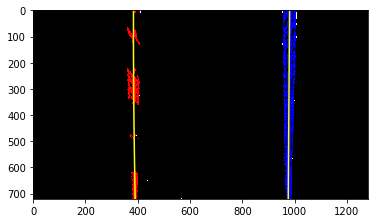

In [29]:
# Create an output image to draw on and visualize the result 
out_img = np.dstack((warp5, warp5, warp5))*255
out_img[lane5[0], lane5[1]] = [255, 0, 0]
out_img[lane5[2], lane5[3]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(fitx5[0], ploty5, color='yellow')
plt.plot(fitx5[1], ploty5, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# 6. Determine the Line Shape and Position

Determine the curvature of the lane and vehicle position with respect to center.

### Measuring Curvature

In [125]:
def measure_curve(ploty, fitx):
    """
    The function calculates the radius of curcature after correcting
    for scale in x and y.
    """
    # Define y-value where we want radius of curvature
    # Here I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters.
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, fitx[0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, fitx[1]*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1]**2)**1.5) / np.absolute(2*right_fit_cr[0]))
    
    return left_curverad, right_curverad

In [126]:
left_curverad5, right_curverad5 = measure_curve(ploty5, fitx5)
print(left_curverad5, 'm', right_curverad5, 'm')

10590.604922946543 m 240926.3874680139 m


In [127]:
undistorted3, warp3, M3, Minv3 = warp_camera(img3)
window_centroids3 = find_window_centroids(warp3, window_width, window_height, margin)
ploty3, lane3, fitx3 = find_ploty(warp3, window_centroids3, window_height, window_width)

(720, 0)

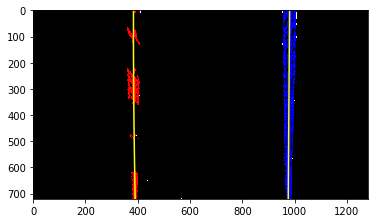

In [128]:
# Create an output image to draw on and visualize the result 
out_img = np.dstack((warp3, warp3, warp3))*255
out_img[lane3[0], lane3[1]] = [255, 0, 0]
out_img[lane3[2], lane3[3]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(fitx3[0], ploty3, color='yellow')
plt.plot(fitx3[1], ploty3, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [129]:
warp_zero = np.zeros_like(warp3).astype(np.uint8)
out_img = np.dstack((warp_zero, warp_zero, warp_zero))

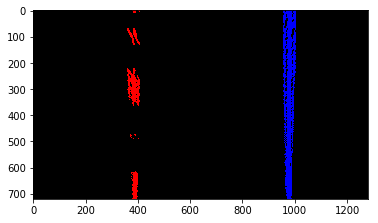

In [130]:
out_img[lane3[0], lane3[1]] = [255, 0, 0]
out_img[lane3[2], lane3[3]] = [0, 0, 255]

plt.imshow(out_img)

In [131]:
newwarp = cv2.warpPerspective(out_img, Minv3, (undistorted3.shape[1], undistorted3.shape[0]))

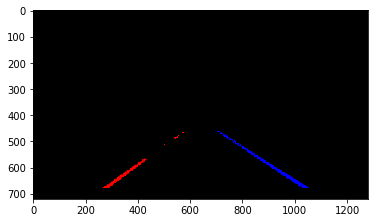

In [132]:
plt.imshow(newwarp)

In [133]:
left_curverad3, right_curverad3 = measure_curve(ploty3, fitx3)
print(left_curverad3, 'm', right_curverad3, 'm')

10590.604922946543 m 240926.3874680139 m


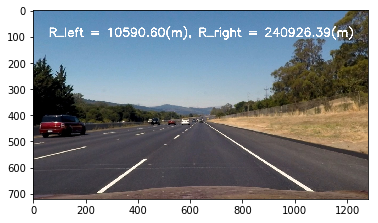

In [134]:
font = cv2.FONT_HERSHEY_SIMPLEX
T = 'R_left = {:0.2f}(m), R_right = {:0.2f}(m)'.format(left_curverad3, right_curverad3)
cv2.putText(undistorted3, T,(60,100), font, 1.5,(255,255,255),4,cv2.LINE_AA)

plt.imshow(undistorted3)

In [135]:
# Generate some fake data to represent lane-line pixels
ploty0 = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx0 = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty0])
rightx0 = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty0])

leftx0 = leftx0[::-1]  # Reverse to match top-to-bottom in y
rightx0 = rightx0[::-1]  # Reverse to match top-to-bottom in y

In [136]:
fitx0 = np.array([leftx0, rightx0])

In [137]:
left_curverad0, right_curverad0 = measure_curve(ploty0, fitx0)
print('R_left = {:0.3f}m, R_right = {:0.3f}m'.format(left_curverad0, right_curverad0))

R_left = 571.648m, R_right = 488.038m


### Drawing

In [138]:
def drawing(undistorted_image, binary_warped, ploty, fitx, Minv):
    """
    The funtion draw the area between detected lane lines on the undistorted original image.
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fitx[0], ploty]))]) 
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitx[1], ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Warp the blank back to original image space using inversed perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    return result

In [139]:
def drawing_lane(undistorted_image, binary_warped, lane, Minv):
    """
    The funtion draw the detected left and right lane lines on the undistorted original image
    in red and blue respectively.
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # draw red left and blue right lane lines
    color_warp[lane[0], lane[1]] = [0, 255, 255]
    color_warp[lane[2], lane[3]] = [255, 255, 0]
    
    # Warp the blank back to original image space using inversed perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, -0.7, 0)
    
    return result

In [140]:
undistorted4 = cal_undistort(img4)
undistorted5 = cal_undistort(img5)

In [141]:
result5 = drawing_lane(undistorted5, warp5, lane5, Minv5)

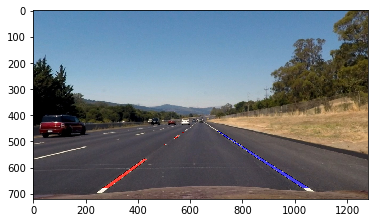

In [142]:
plt.imshow(result5)

# 7. Output

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 7.1 Define Function to Process Image


In [143]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [149]:
def process_image(img_camera):
    # Undistort the original image to draw lane lines on it later
    # Apply color&gradient thresholds and birds-eye perspective on the undistorted image
    undistorted_image, binary_warped, M, Minv = warp_camera(img_camera)
    # Detect the left and right lane lines
    window_centroids = find_window_centroids(binary_warped, window_width=50, window_height=80, margin=40)
    ploty, lane, fitx = find_ploty(binary_warped, window_centroids, window_height=80, window_width=50)
    # Measure curvature and print the radius on the undistorted image
    left_curverad, right_curverad = measure_curve(ploty, fitx)
    font = cv2.FONT_HERSHEY_SIMPLEX
    T_left = 'R_left = {:0.2f}(m),'.format(left_curverad)
    T_right = 'R_right = {:0.2f}(m)'.format(right_curverad)
    cv2.putText(undistorted_image, T_left,(60,100), font, 1.5,(255,0,0), 3, cv2.LINE_AA)
    cv2.putText(undistorted_image, T_right,(700,100), font, 1.5,(0,0,255), 3, cv2.LINE_AA)
    
    # Drawing
    result = drawing_lane(undistorted_image, binary_warped, lane, Minv)
    result = drawing(result, binary_warped, ploty, fitx, Minv)
    
    return result

In [150]:
img6 = mpimg.imread('./test_images/test6.jpg')

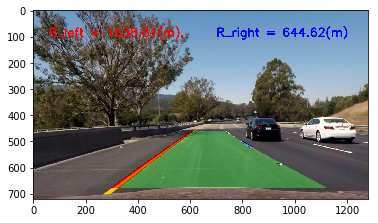

In [151]:
result6 = process_image(img6)
plt.imshow(result6)

## 7.2 Project Video

In [152]:
white_output1 = './test_videos_output/project_video.mp4'

clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
white_clip1 = clip1.fl_image(process_image)
%time white_clip1.write_videofile(white_output1, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4


 99%|█████████▉| 125/126 [02:50<00:01,  1.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video.mp4 

CPU times: user 2min 48s, sys: 10.4 s, total: 2min 58s
Wall time: 2min 52s


In [153]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output1))

## 7.3 Challenge Video

In [147]:
white_output2 = './test_videos_output/challenge_video.mp4'

clip2 = VideoFileClip("./challenge_video.mp4").subclip(0,5)
white_clip2 = clip2.fl_image(process_image)
%time white_clip2.write_videofile(white_output2, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/challenge_video.mp4
[MoviePy] Writing video ./test_videos_output/challenge_video.mp4


100%|██████████| 150/150 [03:05<00:00,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/challenge_video.mp4 

CPU times: user 3min 8s, sys: 10.8 s, total: 3min 18s
Wall time: 3min 7s


In [148]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output2))

## 7.3 Harder Challenge Video

In [ ]:
white_output3 = './test_videos_output/harder_challenge_video.mp4'

clip3 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,5)
white_clip3 = clip3.fl_image(process_image)
%time white_clip3.write_videofile(white_output3, audio=False)

In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output3))